
# Cell 1 — Setup & install


In [ ]:
!pip -q install ultralytics opencv-python pyyaml tqdm

import os, random, shutil
from pathlib import Path
import yaml
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from ultralytics import YOLO

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print("Installed & imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Installed & imported.


# Cell 2 — Mount Drive & paths

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ROOT = Path("/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects")
BASELINE = ROOT / "dataset" / "baseline"
IMG_DIR = BASELINE / "Images"
LBL_DIR = BASELINE / "Labels"

assert ROOT.exists(), f"ROOT not found: {ROOT}"
assert IMG_DIR.exists(), f"Images folder not found: {IMG_DIR}"
assert LBL_DIR.exists(), f"Labels folder not found: {LBL_DIR}"

RUNS_DIR = ROOT / "runs"
RUNS_DIR.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("Images:", IMG_DIR)
print("Labels:", LBL_DIR)
print("Runs:", RUNS_DIR)

IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
ROOT: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects
Images: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/baseline/Images
Labels: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/baseline/Labels
Runs: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs


# Cell 3 — Validate dataset & show class stats

In [ ]:

images = sorted([p for p in IMG_DIR.iterdir() if p.suffix.lower() in IMG_EXTS])
labels = sorted([p for p in LBL_DIR.iterdir() if p.suffix.lower() == ".txt"])

print("Num images:", len(images))
print("Num labels:", len(labels))

img_map = {p.stem: p for p in images}
lbl_map = {p.stem: p for p in labels}

common = sorted(set(img_map.keys()) & set(lbl_map.keys()))
missing_lbl = sorted(set(img_map.keys()) - set(lbl_map.keys()))
missing_img = sorted(set(lbl_map.keys()) - set(img_map.keys()))

print("Matched pairs:", len(common))
print("Images missing labels:", len(missing_lbl))
print("Labels missing images:", len(missing_img))

class_counts = {}
bad_lines = 0

for stem in tqdm(common, desc="Scanning labels"):
    lp = lbl_map[stem]
    with open(lp, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 5:
                bad_lines += 1
                continue
            try:
                c = int(float(parts[0]))
                xc, yc, w, h = map(float, parts[1:])
                if not (0 <= xc <= 1 and 0 <= yc <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
                    bad_lines += 1
                class_counts[c] = class_counts.get(c, 0) + 1
            except:
                bad_lines += 1

print("\nBad/invalid label lines:", bad_lines)
print("Class instance counts:")
for k in sorted(class_counts):
    print(f"  class {k}: {class_counts[k]}")

Num images: 4001
Num labels: 4000
Matched pairs: 4000
Images missing labels: 1
Labels missing images: 0


Scanning labels: 100%|██████████| 4000/4000 [01:24<00:00, 47.57it/s] 


Bad/invalid label lines: 0
Class instance counts:
  class 0: 171
  class 1: 4070
  class 2: 206
  class 3: 650
  class 4: 2934
  class 5: 542
  class 6: 121
  class 7: 517


# Cell 4 — Visualize a few images with bounding boxes

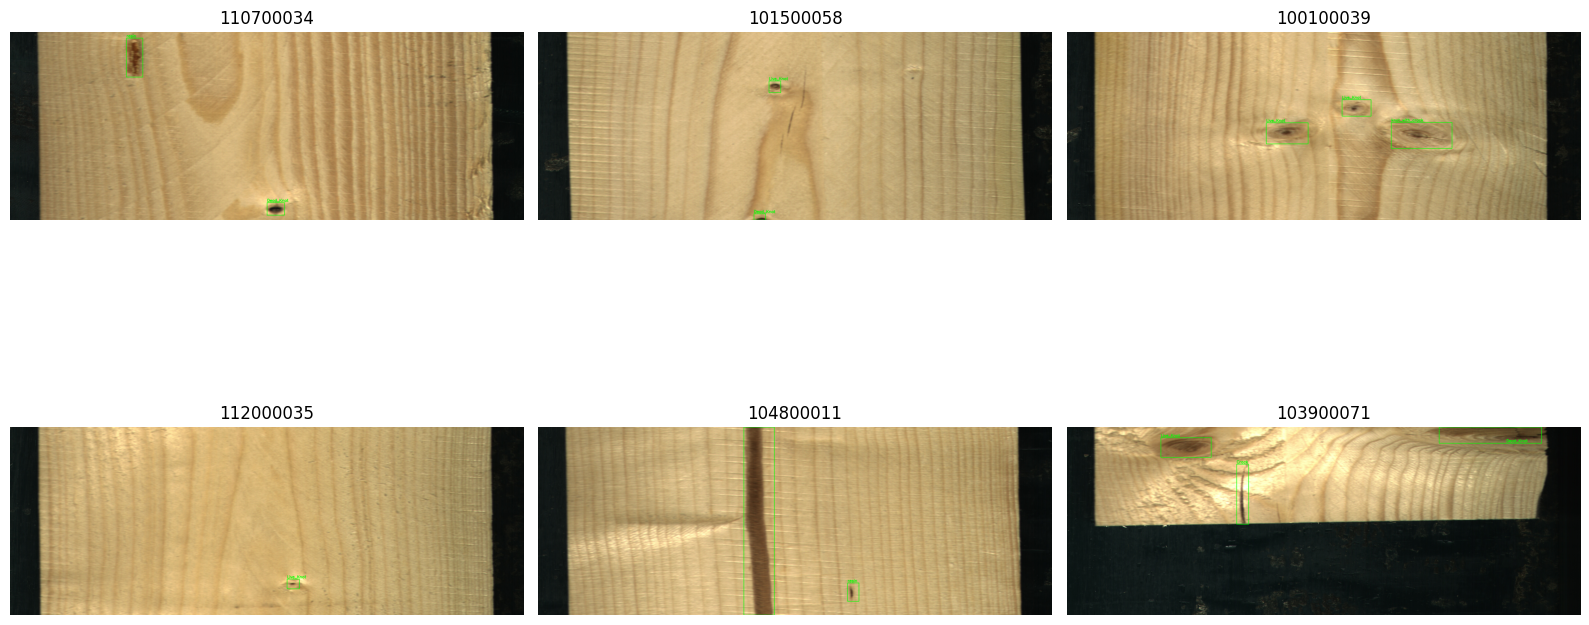

In [ ]:

def yolo_to_xyxy(xc, yc, w, h, W, H):
    x1 = (xc - w/2) * W
    y1 = (yc - h/2) * H
    x2 = (xc + w/2) * W
    y2 = (yc + h/2) * H
    return int(round(x1)), int(round(y1)), int(round(x2)), int(round(y2))

def draw_boxes(img_bgr, label_path, class_names=None, thickness=2):
    img = img_bgr.copy()
    H, W = img.shape[:2]
    with open(label_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            c, xc, yc, w, h = line.split()
            c = int(float(c))
            xc, yc, w, h = map(float, [xc, yc, w, h])
            x1, y1, x2, y2 = yolo_to_xyxy(xc, yc, w, h, W, H)
            cv2.rectangle(img, (x1,y1), (x2,y2), (0,255,0), thickness)
            name = str(c) if class_names is None else class_names.get(c, str(c))
            cv2.putText(img, name, (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
    return img

# Adjust if your class-id mapping differs
CLASS_NAMES = {
    0: "Quartzity",
    1: "Live_Knot",
    2: "Marrow",
    3: "resin",
    4: "Dead_Knot",
    5: "knot_with_crack",
    6: "Knot_missing",
    7: "Crack",
}

sample_stems = random.sample(common, k=min(6, len(common)))

plt.figure(figsize=(16, 10))
for i, stem in enumerate(sample_stems, 1):
    img_path = img_map[stem]
    lbl_path = lbl_map[stem]
    img = cv2.imread(str(img_path))
    vis = draw_boxes(img, lbl_path, CLASS_NAMES)
    vis_rgb = cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i)
    plt.imshow(vis_rgb)
    plt.title(stem)
    plt.axis("off")
plt.tight_layout()
plt.show()

# Cell 5 — Split into train/val/test (YOLO)

In [ ]:
BASE_SPLIT = ROOT / "dataset" / "baseline_split_yolo"
data_yaml_baseline = BASE_SPLIT / "data.yaml"

def has_split_dataset(ds_root: Path) -> bool:
    needed = [
        ds_root / "images/train", ds_root / "images/val", ds_root / "images/test",
        ds_root / "labels/train", ds_root / "labels/val", ds_root / "labels/test",
        ds_root / "data.yaml"
    ]
    return all(p.exists() for p in needed)

if has_split_dataset(BASE_SPLIT):
    print("Baseline split already exists. Reusing:", BASE_SPLIT)
else:
    print("Creating baseline split at:", BASE_SPLIT)

    for p in [
        BASE_SPLIT / "images" / "train",
        BASE_SPLIT / "images" / "val",
        BASE_SPLIT / "images" / "test",
        BASE_SPLIT / "labels" / "train",
        BASE_SPLIT / "labels" / "val",
        BASE_SPLIT / "labels" / "test",
    ]:
        p.mkdir(parents=True, exist_ok=True)

    train_ratio, val_ratio, test_ratio = 0.7, 0.2, 0.1
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-9

    stems = common[:]
    random.shuffle(stems)

    n = len(stems)
    n_train = int(round(n * train_ratio))
    n_val = int(round(n * val_ratio))
    train_stems = stems[:n_train]
    val_stems = stems[n_train:n_train+n_val]
    test_stems = stems[n_train+n_val:]

    print("Split sizes:", len(train_stems), len(val_stems), len(test_stems))

    def copy_pair(stem, split_name, out_root):
        src_img = img_map[stem]
        src_lbl = lbl_map[stem]
        shutil.copy2(src_img, out_root / "images" / split_name / src_img.name)
        shutil.copy2(src_lbl, out_root / "labels" / split_name / src_lbl.name)

    for s in tqdm(train_stems, desc="Copy train"):
        copy_pair(s, "train", BASE_SPLIT)
    for s in tqdm(val_stems, desc="Copy val"):
        copy_pair(s, "val", BASE_SPLIT)
    for s in tqdm(test_stems, desc="Copy test"):
        copy_pair(s, "test", BASE_SPLIT)

    data = {
        "path": str(BASE_SPLIT),
        "train": "images/train",
        "val": "images/val",
        "test": "images/test",
        "names": [CLASS_NAMES[i] for i in range(8)]
    }
    with open(data_yaml_baseline, "w") as f:
        yaml.safe_dump(data, f, sort_keys=False)

    print("Wrote:", data_yaml_baseline)

Baseline split already exists. Reusing: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/baseline_split_yolo


# Cell 6 — Train YOLOv8n (baseline split) — 50 epochs

In [ ]:
exp_v8_base = "wood_yolov8n_baseline_e50"
run_v8_base = RUNS_DIR / "detect" / exp_v8_base
best_v8_base = run_v8_base / "weights" / "best.pt"

if best_v8_base.exists():
    print("YOLOv8n baseline already trained. Reusing:", best_v8_base)
else:
    print("Training YOLOv8n baseline:", exp_v8_base)
    YOLO("yolov8n.pt").train(
        data=str(data_yaml_baseline),
        epochs=50,
        imgsz=1024,
        batch=4,
        device=0,
        project=str(RUNS_DIR),
        name=exp_v8_base,
        exist_ok=True,
        verbose=True
    )

Training YOLOv8n baseline: wood_yolov8n_baseline_e50
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA L4, 22563MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/baseline_split_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, n

In [ ]:
from pathlib import Path

file_path = Path('/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/wood_yolo11n_baseline_e50/weights/best.pt')

if file_path.exists():
    print(f"The file '{file_path}' is available.")
else:
    print(f"The file '{file_path}' is NOT available.")

The file '/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/wood_yolo11n_baseline_e50/weights/best.pt' is available.


# Cell 7 — Train YOLO11n (baseline split) — 50 epochs

In [ ]:

exp_y11_base = "wood_yolo11n_baseline_e50"
run_y11_base = RUNS_DIR / "detect" / exp_y11_base
best_y11_base = run_y11_base / "weights" / "best.pt"

if best_y11_base.exists():
    print("YOLO11n baseline already trained. Reusing:", best_y11_base)
else:
    print("Training YOLO11n baseline:", exp_y11_base)
    YOLO("yolo11n.pt").train(
        data=str(data_yaml_baseline),
        epochs=50,
        imgsz=1024,
        batch=4,
        device=0,
        project=str(RUNS_DIR),
        name=exp_y11_base,
        exist_ok=True,
        verbose=True
    )

Training YOLO11n baseline: wood_yolo11n_baseline_e50
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA L4, 22563MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/baseline_split_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, n

# Cell 8 — Save random predictions (baseline) into run folder

In [ ]:

def save_random_predictions(best_weights_path, data_yaml_path, out_dir, n_images=12, split="test", conf=0.25):
    out_dir = Path(out_dir)
    pred_dir = out_dir / "predictions"
    if pred_dir.exists():
        print("Predictions already exist. Skipping:", pred_dir)
        return

    cfg = yaml.safe_load(open(data_yaml_path))
    ds_root = Path(cfg["path"])
    split_img_dir = ds_root / f"images/{split}"
    imgs = sorted([p for p in split_img_dir.iterdir() if p.suffix.lower() in IMG_EXTS])
    if len(imgs) == 0:
        raise RuntimeError(f"No images in {split_img_dir}")

    pick = random.sample(imgs, k=min(n_images, len(imgs)))

    m = YOLO(str(best_weights_path))
    m.predict(
        source=[str(p) for p in pick],
        save=True,
        project=str(out_dir),
        name="predictions",
        exist_ok=True,
        conf=conf
    )
    print("Saved predictions to:", pred_dir)

save_random_predictions(best_v8_base, data_yaml_baseline, run_v8_base, n_images=12, split="test")
save_random_predictions(best_y11_base, data_yaml_baseline, run_y11_base, n_images=12, split="test")


0: 384x1024 1 Live_Knot, 1 resin, 2 Dead_Knots, 5.9ms
1: 384x1024 4 Live_Knots, 5.9ms
2: 384x1024 2 Live_Knots, 1 Dead_Knot, 5.9ms
3: 384x1024 (no detections), 5.9ms
4: 384x1024 1 Live_Knot, 1 Dead_Knot, 5.9ms
5: 384x1024 2 Live_Knots, 1 resin, 5.9ms
6: 384x1024 1 Live_Knot, 5.9ms
7: 384x1024 7 Dead_Knots, 5.9ms
8: 384x1024 1 Live_Knot, 1 Dead_Knot, 5.9ms
9: 384x1024 2 Live_Knots, 5.9ms
10: 384x1024 1 Live_Knot, 5.9ms
11: 384x1024 1 Live_Knot, 2 Dead_Knots, 5.9ms
Speed: 3.2ms preprocess, 5.9ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 1024)
Results saved to /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_baseline_e50/predictions
Saved predictions to: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_baseline_e50/predictions

0: 384x1024 1 Live_Knot, 1 resin, 1 knot_with_crack, 3.3ms
1: 384x1024 2 Live_Knots, 1 knot_with_crack, 3.3ms
2: 384x1024 (no detections), 3.3ms
3: 384x1024 3 Live_Knots, 3.3

# Cell 9 — Mosaic augmentation for rare classes (OFFLINE)
   - Creates a NEW dataset folder (no overwrite)
   - Adds mosaic images ONLY to train split

In [ ]:

AUG_SPLIT = ROOT / "dataset" / "aug_mosaic_weakMAP_lt04_v1_yolo"
data_yaml_aug = AUG_SPLIT / "data.yaml"

MAP_THRESH = 0.40  # per-class mAP50-95 threshold

def find_image_by_stem(img_dir: Path, stem: str) -> Path | None:
    for ext in IMG_EXTS:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            return p
    g = list(img_dir.glob(stem + ".*"))
    return g[0] if g else None

def copy_tree(src: Path, dst: Path):
    src, dst = Path(src), Path(dst)
    for f in src.rglob("*"):
        if f.is_file():
            rel = f.relative_to(src)
            (dst / rel.parent).mkdir(parents=True, exist_ok=True)
            shutil.copy2(f, dst / rel)

def read_yolo_labels(lbl_path, W, H):
    boxes = []
    with open(lbl_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            if len(parts) != 5:
                continue
            c = int(float(parts[0]))
            xc, yc, w, h = map(float, parts[1:])
            x1, y1, x2, y2 = yolo_to_xyxy(xc, yc, w, h, W, H)
            x1 = max(0, min(W - 1, x1)); x2 = max(0, min(W - 1, x2))
            y1 = max(0, min(H - 1, y1)); y2 = max(0, min(H - 1, y2))
            if x2 > x1 and y2 > y1:
                boxes.append((c, x1, y1, x2, y2))
    return boxes

def to_yolo_norm(x1, y1, x2, y2, W, H):
    xc = ((x1 + x2) / 2) / W
    yc = ((y1 + y2) / 2) / H
    w = (x2 - x1) / W
    h = (y2 - y1) / H
    return xc, yc, w, h

def make_mosaic(train_img_dir: Path, train_lbl_dir: Path, sample_stems, out_size=(1024, 1024)):
    outW, outH = out_size
    tileW, tileH = outW // 2, outH // 2

    positions = [(0, 0), (tileW, 0), (0, tileH), (tileW, tileH)]
    mosaic = np.zeros((outH, outW, 3), dtype=np.uint8)
    mosaic_lines = []

    for stem, (ox, oy) in zip(sample_stems, positions):
        img_path = find_image_by_stem(train_img_dir, stem)
        if img_path is None:
            continue
        lbl_path = train_lbl_dir / f"{stem}.txt"
        if not lbl_path.exists():
            continue

        img = cv2.imread(str(img_path))
        if img is None:
            continue

        H, W = img.shape[:2]
        boxes = read_yolo_labels(lbl_path, W, H)

        img_res = cv2.resize(img, (tileW, tileH), interpolation=cv2.INTER_AREA)
        mosaic[oy:oy + tileH, ox:ox + tileW] = img_res

        sx, sy = tileW / W, tileH / H
        for (c, x1, y1, x2, y2) in boxes:
            x1r = x1 * sx + ox
            x2r = x2 * sx + ox
            y1r = y1 * sy + oy
            y2r = y2 * sy + oy

            x1r = max(0, min(outW - 1, x1r)); x2r = max(0, min(outW - 1, x2r))
            y1r = max(0, min(outH - 1, y1r)); y2r = max(0, min(outH - 1, y2r))

            if x2r > x1r and y2r > y1r:
                xc, yc, w, h = to_yolo_norm(x1r, y1r, x2r, y2r, outW, outH)
                mosaic_lines.append(f"{c} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}")

    return mosaic, mosaic_lines

def has_aug_dataset(ds_root: Path) -> bool:
    needed = [
        ds_root / "images/train", ds_root / "images/val", ds_root / "images/test",
        ds_root / "labels/train", ds_root / "labels/val", ds_root / "labels/test",
        ds_root / "data.yaml"
    ]
    return all(p.exists() for p in needed)

def detect_weak_classes_from_val(best_weights: Path, data_yaml: Path, imgsz=1024, device=0, map_thresh=0.40):
    """
    Uses model.val() to get per-class mAP50-95.
    Weak classes: per-class mAP50-95 < map_thresh
    """
    assert best_weights.exists(), f"Missing weights: {best_weights}"
    assert data_yaml.exists(), f"Missing data yaml: {data_yaml}"

    m = YOLO(str(best_weights))
    metrics = m.val(data=str(data_yaml), split="val", imgsz=imgsz, device=device, verbose=False)

    # Ultralytics: metrics.box.maps is per-class mAP50-95 (array length = nc)
    if not hasattr(metrics, "box") or not hasattr(metrics.box, "maps"):
        raise RuntimeError("Could not read per-class mAP from metrics (metrics.box.maps not found).")

    maps = metrics.box.maps  # numpy array
    names = getattr(metrics, "names", None) or getattr(m, "names", None) or {}

    weak = [i for i, v in enumerate(maps) if (v is not None and float(v) < map_thresh)]
    weak_info = [(i, names.get(i, str(i)), float(maps[i])) for i in weak]
    weak_info_sorted = sorted(weak_info, key=lambda x: x[2])

    return weak, weak_info_sorted, maps

if has_aug_dataset(AUG_SPLIT):
    print("Augmented dataset already exists. Reusing:", AUG_SPLIT)
else:
    print("Creating augmented dataset at:", AUG_SPLIT)

    # Choose which baseline model to evaluate for weak classes
    if best_v8_base.exists():
        baseline_weights_for_weak = best_v8_base
        print("Using YOLOv8 baseline weights for weak-class detection:", baseline_weights_for_weak)
    elif best_y11_base.exists():
        baseline_weights_for_weak = best_y11_base
        print("Using YOLO11 baseline weights for weak-class detection:", baseline_weights_for_weak)
    else:
        raise RuntimeError("No baseline trained weights found. Train baseline first so we can compute per-class mAP.")

    weak_classes, weak_info_sorted, _ = detect_weak_classes_from_val(
        best_weights=baseline_weights_for_weak,
        data_yaml=data_yaml_baseline,
        imgsz=1024,
        device=0,
        map_thresh=MAP_THRESH
    )

    print(f"Weak classes (per-class mAP50-95 < {MAP_THRESH}):")
    if len(weak_info_sorted) == 0:
        print("  None. (All classes >= threshold)")
    else:
        for cid, cname, v in weak_info_sorted:
            print(f"  class {cid:>2} ({cname}): mAP50-95={v:.3f}")

    # Create structure
    for p in [
        AUG_SPLIT / "images" / "train",
        AUG_SPLIT / "images" / "val",
        AUG_SPLIT / "images" / "test",
        AUG_SPLIT / "labels" / "train",
        AUG_SPLIT / "labels" / "val",
        AUG_SPLIT / "labels" / "test",
    ]:
        p.mkdir(parents=True, exist_ok=True)

    # Copy baseline split into augmented root
    copy_tree(BASE_SPLIT / "images", AUG_SPLIT / "images")
    copy_tree(BASE_SPLIT / "labels", AUG_SPLIT / "labels")

    train_img_dir = AUG_SPLIT / "images" / "train"
    train_lbl_dir = AUG_SPLIT / "labels" / "train"
    train_label_files = sorted(train_lbl_dir.glob("*.txt"))

    # Map each training image -> set of classes it contains
    img_contains_class = {}
    for lp in train_label_files:
        stem = lp.stem
        cls_set = set()
        with open(lp, "r") as f:
            for line in f:
                if not line.strip():
                    continue
                parts = line.split()
                if len(parts) < 1:
                    continue
                cls_set.add(int(float(parts[0])))
        img_contains_class[stem] = cls_set

    # Candidate stems: images containing at least one weak class
    weak_set = set(weak_classes)
    weak_stems = [s for s, cls_set in img_contains_class.items() if weak_set.intersection(cls_set)]
    print("Train images containing weak classes:", len(weak_stems))

    # If none are weak (or no stems match), do not generate mosaics
    if len(weak_classes) == 0 or len(weak_stems) == 0:
        print("No weak classes (or no matching images). Skipping mosaic generation.")
    else:
        pool = weak_stems

        # How many mosaics to generate: 30% of weak-containing images, capped
        num_mosaics = min(500, max(0, int(0.30 * len(weak_stems))))
        print("Will generate mosaics:", num_mosaics)

        created = 0
        for i in tqdm(range(num_mosaics), desc="Creating mosaics"):
            chosen = random.choices(pool, k=4)  # oversample weak-class images
            mosaic_img, mosaic_lines = make_mosaic(train_img_dir, train_lbl_dir, chosen, out_size=(1024, 1024))
            if len(mosaic_lines) == 0:
                continue

            out_stem = f"mosaic_weakmap_{i:05d}"
            out_img = train_img_dir / f"{out_stem}.jpg"
            out_lbl = train_lbl_dir / f"{out_stem}.txt"

            cv2.imwrite(str(out_img), mosaic_img)
            with open(out_lbl, "w") as f:
                f.write("\n".join(mosaic_lines) + "\n")
            created += 1

        print("Created mosaic images:", created)

    # Write YAML for augmented dataset
    data_aug = {
        "path": str(AUG_SPLIT),
        "train": "images/train",
        "val": "images/val",
        "test": "images/test",
        "names": [CLASS_NAMES[i] for i in range(8)]
    }
    with open(data_yaml_aug, "w") as f:
        yaml.safe_dump(data_aug, f, sort_keys=False)

    print("Wrote:", data_yaml_aug)

Creating augmented dataset at: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/aug_mosaic_weakMAP_lt04_v1_yolo
Using YOLOv8 baseline weights for weak-class detection: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_baseline_e50/weights/best.pt
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA L4, 22563MiB)
Model summary (fused): 73 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 347.6±77.2 MB/s, size: 814.6 KB)
val: Scanning /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/baseline_split_yolo/labels/val.cache... 800 images, 73 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 800/800 239.7Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 50/50 5.6it/s 9.0s
                   all        800       1865      0.651      0.669      0.677      0.406
Speed: 0.9ms preprocess, 1.7ms in

Creating mosaics: 100%|██████████| 500/500 [01:32<00:00,  5.39it/s]


Created mosaic images: 500
Wrote: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/aug_mosaic_weakMAP_lt04_v1_yolo/data.yaml


# Cell 10 — Train YOLOv8n on AUG dataset — 50 epochs

In [ ]:

exp_v8_aug = "wood_yolov8n_augMosaicRare_e50"
run_v8_aug = RUNS_DIR / "detect" / exp_v8_aug
best_v8_aug = run_v8_aug / "weights" / "best.pt"

if best_v8_aug.exists():
    print("YOLOv8n augmented already trained. Reusing:", best_v8_aug)
else:
    print("Training YOLOv8n augmented:", exp_v8_aug)
    YOLO("yolov8n.pt").train(
        data=str(data_yaml_aug),
        epochs=50,
        imgsz=1024,
        batch=4,
        device=0,
        project=str(RUNS_DIR),
        name=exp_v8_aug,
        exist_ok=True,
        verbose=True
    )

Training YOLOv8n augmented: wood_yolov8n_augMosaicRare_e50
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA L4, 22563MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/aug_mosaic_weakMAP_lt04_v1_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, 

# Cell 11 — Train YOLO11n on AUG dataset — 50 epochs

In [ ]:

exp_y11_aug = "wood_yolo11n_augMosaicRare_e50"
run_y11_aug = RUNS_DIR / "detect" / exp_y11_aug
best_y11_aug = run_y11_aug / "weights" / "best.pt"

if best_y11_aug.exists():
    print("YOLO11n augmented already trained. Reusing:", best_y11_aug)
else:
    print("Training YOLO11n augmented:", exp_y11_aug)
    YOLO("yolo11n.pt").train(
        data=str(data_yaml_aug),
        epochs=50,
        imgsz=1024,
        batch=4,
        device=0,
        project=str(RUNS_DIR),
        name=exp_y11_aug,
        exist_ok=True,
        verbose=True
    )

Training YOLO11n augmented: wood_yolo11n_augMosaicRare_e50
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA L4, 22563MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/aug_mosaic_weakMAP_lt04_v1_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, 

# Cell 12 — Save random predictions (AUG runs) into run folder

In [ ]:

save_random_predictions(best_v8_aug, data_yaml_aug, run_v8_aug, n_images=12, split="test")
save_random_predictions(best_y11_aug, data_yaml_aug, run_y11_aug, n_images=12, split="test")


0: 384x1024 1 Dead_Knot, 1.2ms
1: 384x1024 1 resin, 2 Dead_Knots, 1.2ms
2: 384x1024 4 Live_Knots, 1.2ms
3: 384x1024 3 Live_Knots, 1.2ms
4: 384x1024 (no detections), 1.2ms
5: 384x1024 1 Live_Knot, 1 Dead_Knot, 1.2ms
6: 384x1024 1 Live_Knot, 1.2ms
7: 384x1024 1 Live_Knot, 1.2ms
8: 384x1024 8 Dead_Knots, 1.2ms
9: 384x1024 1 Live_Knot, 1 Dead_Knot, 1.2ms
10: 384x1024 2 Live_Knots, 1.2ms
11: 384x1024 1 Live_Knot, 1.2ms
Speed: 3.1ms preprocess, 1.2ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 1024)
Results saved to /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_augMosaicRare_e50/predictions
Saved predictions to: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_augMosaicRare_e50/predictions

0: 384x1024 1 Live_Knot, 2 Dead_Knots, 1.4ms
1: 384x1024 1 Live_Knot, 1 resin, 1.4ms
2: 384x1024 2 Live_Knots, 1.4ms
3: 384x1024 (no detections), 1.4ms
4: 384x1024 2 Live_Knots, 1.4ms
5: 384x1024 3 Dead_Knots, 1.4m

# Cell 13 — Compare all 4 runs in one table (metrics)
  - Reads each run's results.csv and takes BEST epoch
  - Saves comparison CSV into ROOT/runs/

In [ ]:

def load_best_metrics(run_dir: Path):
    run_dir = Path(run_dir)
    csv_path = run_dir / "results.csv"
    if not csv_path.exists():
        return {"run": run_dir.name, "error": "results.csv not found"}

    df = pd.read_csv(csv_path)

    # Column detection (robust across minor Ultralytics changes)
    def find_col(contains_any):
        for c in df.columns:
            if any(s in c for s in contains_any):
                return c
        return None

    col_map50 = find_col(["metrics/mAP50(B)", "mAP50(B)", "mAP50 "])
    col_map5095 = find_col(["metrics/mAP50-95(B)", "metrics/mAP50-95", "mAP50-95"])
    col_p = find_col(["metrics/precision(B)", "precision(B)", "precision"])
    col_r = find_col(["metrics/recall(B)", "recall(B)", "recall"])

    if col_map5095 is None:
        return {"run": run_dir.name, "error": "mAP50-95 column not found"}

    best_idx = df[col_map5095].idxmax()
    row = df.loc[best_idx]

    out = {
        "run": run_dir.name,
        "best_epoch": int(row["epoch"]) if "epoch" in df.columns else int(best_idx),
        "mAP50": float(row[col_map50]) if col_map50 else np.nan,
        "mAP50-95": float(row[col_map5095]),
        "precision": float(row[col_p]) if col_p else np.nan,
        "recall": float(row[col_r]) if col_r else np.nan,
        "weights_best": str((run_dir / "weights" / "best.pt").resolve()),
        "error": ""
    }
    return out

runs = {
    "YOLOv8n (baseline)": run_v8_base,
    "YOLO11n (baseline)": run_y11_base,
    "YOLOv8n (aug mosaic rare)": run_v8_aug,
    "YOLO11n (aug mosaic rare)": run_y11_aug,
}

rows = []
for label, rdir in runs.items():
    m = load_best_metrics(rdir)
    m["model"] = label
    rows.append(m)

cmp = pd.DataFrame(rows)
cmp = cmp[["model", "run", "best_epoch", "mAP50", "mAP50-95", "precision", "recall", "weights_best", "error"]]

cmp_path = RUNS_DIR / "wood_defects_model_comparison.csv"
cmp.to_csv(cmp_path, index=False)

print("Saved comparison to:", cmp_path)
cmp

Saved comparison to: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/wood_defects_model_comparison.csv


,model,run,best_epoch,mAP50,mAP50-95,precision,recall,weights_best,error
0,YOLOv8n (baseline),wood_yolov8n_baseline_e50,45,0.67662,0.40490,0.69993,0.62077,/content/drive/MyDrive/AI Master Courses/WoodS...,
1,YOLO11n (baseline),wood_yolo11n_baseline_e50,47,0.67282,0.40260,0.71844,0.62744,/content/drive/MyDrive/AI Master Courses/WoodS...,
2,YOLOv8n (aug mosaic rare),wood_yolov8n_augMosaicRare_e50,32,0.68071,0.39695,0.68921,0.66078,/content/drive/MyDrive/AI Master Courses/WoodS...,
3,YOLO11n (aug mosaic rare),wood_yolo11n_augMosaicRare_e50,50,0.67650,0.39994,0.68944,0.65171,/content/drive/MyDrive/AI Master Courses/WoodS...,


In [ ]:
# ==========================================================
# Export YOLOv8 baseline to ONNX and TorchScript
# ==========================================================
from pathlib import Path
from ultralytics import YOLO

ROOT = Path("/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects")

# Path to trained baseline model
best_pt = ROOT / "runs/detect/wood_yolov8n_baseline_e50/weights/best.pt"
assert best_pt.exists(), f"Model not found: {best_pt}"

# Export folder
EXPORT_DIR = ROOT / "exports" / "yolov8n_baseline"
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

print("Loading model:", best_pt)
model = YOLO(str(best_pt))

# ----------------------------------------------------------
# 1) Export to ONNX
# ----------------------------------------------------------
print("\nExporting to ONNX...")
onnx_path = model.export(
    format="onnx",
    imgsz=1024,        # use same size as training
    opset=12,
    dynamic=True,      # allows variable image sizes
    simplify=True      # optional but recommended
)

# Move ONNX to export folder (Ultralytics saves in run dir)
onnx_path = Path(onnx_path)
onnx_dst = EXPORT_DIR / "wood_yolov8n_baseline.onnx"
onnx_path.rename(onnx_dst)

print("ONNX saved to:", onnx_dst)

# ----------------------------------------------------------
# 2) Export to TorchScript
# ----------------------------------------------------------
print("\nExporting to TorchScript...")
ts_path = model.export(
    format="torchscript",
    imgsz=1024
)

ts_path = Path(ts_path)
ts_dst = EXPORT_DIR / "wood_yolov8n_baseline.torchscript"
ts_path.rename(ts_dst)

print("TorchScript saved to:", ts_dst)

print("\nExport completed.")

Loading model: /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_baseline_e50/weights/best.pt

Exporting to ONNX...
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CPU (Intel Xeon CPU @ 2.20GHz)
Model summary (fused): 73 layers, 3,007,208 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from '/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_baseline_e50/weights/best.pt' with input shape (1, 3, 1024, 1024) BCHW and output shape(s) (1, 12, 21504) (6.0 MB)

ONNX: starting export with onnx 1.20.1 opset 12...
ONNX: slimming with onnxslim 0.1.85...
ONNX: export success ✅ 2.2s, saved as '/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_baseline_e50/weights/best.onnx' (11.8 MB)

Export complete (2.5s)
Results saved to /content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/runs/detect/wood_yolov8n_baseline_e50/weights
Predict:         yolo predict task=detect model=/conte

In [ ]:
exp_v8_base = "wood_yolov8n_baseline_e100"
run_v8_base = RUNS_DIR / "detect" / exp_v8_base
best_v8_base = run_v8_base / "weights" / "best.pt"

if best_v8_base.exists():
    print("YOLOv8n baseline already trained. Reusing:", best_v8_base)
else:
    print("Training YOLOv8n baseline:", exp_v8_base)
    YOLO("yolov8n.pt").train(
        data=str(data_yaml_baseline),
        epochs=100,
        imgsz=1024,
        batch=4,
        device=0,
        project=str(RUNS_DIR),
        name=exp_v8_base,
        exist_ok=True,
        verbose=True
    )

Training YOLOv8n baseline: wood_yolov8n_baseline_e100
Ultralytics 8.4.16 🚀 Python-3.12.12 torch-2.10.0+cu128 CUDA:0 (NVIDIA L4, 22563MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/AI Master Courses/WoodSurfaceDefects/dataset/baseline_split_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1024, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0,